## 加载功能

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor

In [2]:
#设置数据输入路径和导出路径
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
#用原子序数代替原子名称
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
#设置显示参数
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
#显示当前路径下的文件夹
os.listdir(DATA_PATH)

['data-of-distance-qm9', 'champs-scalar-coupling']

In [5]:
#定义缩小消耗内存函数
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 加载数据集

In [6]:
train_csv = pd.read_csv('../input/data-of-distance-qm9-giba/fin_train.csv')
test_csv = pd.read_csv('../input/data-of-distance-qm9-giba/fin_test.csv')

In [7]:
#减小消耗内存，防止内存不足
train_csv = reduce_mem_usage(train_csv,verbose = True)
test_csv = reduce_mem_usage(test_csv,verbose = True)

Mem. usage decreased to 630.81 Mb (50.7% reduction)
Mem. usage decreased to 329.75 Mb (50.7% reduction)


In [8]:
train_csv.set_index('id',inplace = True)
test_csv.set_index('id',inplace = True)

In [9]:
train_csv.head(10)

,atom_index_1,atom_index_0,scalar_coupling_constant,linkM0,linkM1,inv_dist0R,mean_molecule_atom_0_dist_xyz,max_molecule_atom_0_dist_xyz,sd_molecule_atom_0_dist_xyz,mean_molecule_atom_1_dist_xyz,max_molecule_atom_1_dist_xyz,sd_molecule_atom_1_dist_xyz,coulomb_C.x,coulomb_H.x,coulomb_N.x,coulomb_O.x,yukawa_H.x,coulomb_C.y,coulomb_H.y,coulomb_O.y,yukawa_C.y,yukawa_H.y,vander_C.y,distC0,distC1,adH1,adC2,adC3,adC4,type,molecule_index,mulliken_min,mulliken_max,mulliken_atom_0,mulliken_atom_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,84.807602,0.0,0.680487,0.003337,1.610344,1.783157,0.345594,1.091950,1.091953,0.000003,0.915790,1.682424,0.0,0.0,0.282831,0.000000,3.663172,0.0,0.000000,1.229220,0.000000,1.091953,0.272988,1.783120,0.0,0.0,0.0,1JHC,1,-0.535689,0.133923,0.133921,-0.535689
1,2,1,-11.257000,0.0,-4.886227,0.003337,1.610344,1.783157,0.345594,1.783120,1.783120,0.000000,0.915790,1.682424,0.0,0.0,0.282831,0.915792,1.682424,0.0,0.307304,0.282831,0.589902,0.000000,0.000000,1.783147,0.0,0.0,0.0,2JHH,1,-0.535689,0.133923,0.133921,0.133922
2,3,1,-11.254800,0.0,-2.006931,0.003337,1.610344,1.783157,0.345594,1.783153,1.783158,0.000007,0.915790,1.682424,0.0,0.0,0.282831,0.915796,1.682415,0.0,0.307307,0.282827,0.589919,0.000000,0.000000,1.783120,0.0,0.0,0.0,2JHH,1,-0.535689,0.133923,0.133921,0.133923
3,4,1,-11.254300,0.0,-0.982600,0.003337,1.610344,1.783157,0.345594,1.783151,1.783157,0.000005,0.915790,1.682424,0.0,0.0,0.282831,0.915795,1.682415,0.0,0.307306,0.282827,0.589915,0.000000,0.000000,1.783120,0.0,0.0,0.0,2JHH,1,-0.535689,0.133923,0.133921,0.133923
4,0,2,84.807404,0.0,0.680487,0.003348,1.552753,1.783158,0.399065,1.091950,1.091953,0.000003,0.915792,1.682424,0.0,0.0,0.282831,0.000000,3.663172,0.0,0.000000,1.229220,0.000000,1.091952,0.272988,1.783148,0.0,0.0,0.0,1JHC,1,-0.535689,0.133923,0.133922,-0.535689
5,3,2,-11.254100,0.0,-2.006931,0.003348,1.552753,1.783158,0.399065,1.783153,1.783158,0.000007,0.915792,1.682424,0.0,0.0,0.282831,0.915796,1.682415,0.0,0.307307,0.282827,0.589919,0.000000,0.000000,1.783148,0.0,0.0,0.0,2JHH,1,-0.535689,0.133923,0.133922,0.133923
6,4,2,-11.254800,0.0,-0.982600,0.003348,1.552753,1.783158,0.399065,1.783151,1.783157,0.000005,0.915792,1.682424,0.0,0.0,0.282831,0.915795,1.682415,0.0,0.307306,0.282827,0.589915,0.000000,0.000000,1.783158,0.0,0.0,0.0,2JHH,1,-0.535689,0.133923,0.133922,0.133923
7,0,3,84.809303,0.0,0.680487,0.003359,1.437547,1.783148,0.488753,1.091950,1.091953,0.000003,0.915796,1.682415,0.0,0.0,0.282827,0.000000,3.663172,0.0,0.000000,1.229220,0.000000,1.091946,0.272987,1.783148,0.0,0.0,0.0,1JHC,1,-0.535689,0.133923,0.133923,-0.535689
8,4,3,-11.254300,0.0,-0.982600,0.003359,1.437547,1.783148,0.488753,1.783151,1.783157,0.000005,0.915796,1.682415,0.0,0.0,0.282827,0.915795,1.682415,0.0,0.307306,0.282827,0.589915,0.000000,0.000000,0.000000,0.0,0.0,0.0,2JHH,1,-0.535689,0.133923,0.133923,0.133923


In [10]:
test_csv.head(10)

,atom_index_1,atom_index_0,linkM0,linkM1,inv_dist0R,mean_molecule_atom_0_dist_xyz,max_molecule_atom_0_dist_xyz,sd_molecule_atom_0_dist_xyz,mean_molecule_atom_1_dist_xyz,max_molecule_atom_1_dist_xyz,sd_molecule_atom_1_dist_xyz,coulomb_C.x,coulomb_H.x,coulomb_N.x,coulomb_O.x,yukawa_H.x,coulomb_C.y,coulomb_H.y,coulomb_O.y,yukawa_C.y,yukawa_H.y,vander_C.y,distC0,distC1,adH1,adC2,adC3,adC4,type,molecule_index,mulliken_min,mulliken_max,mulliken_atom_0,mulliken_atom_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4658147,0,2,0.029943,-0.142512,0.007670,2.215518,3.323277,1.131280,1.661639,2.261178,0.847877,1.383779,0.300908,0.0,0.000000,0.010843,0.833973,1.383779,0.000000,0.251419,0.371610,0.336444,1.661639,1.661639,3.323277,0.000000,0.0,0.0,2JHC,4,-0.207019,0.207019,0.207019,-0.207019
4658148,1,2,0.029943,-0.140758,0.007670,2.215518,3.323277,1.131280,1.661639,2.261178,0.847877,1.383779,0.300908,0.0,0.000000,0.010843,0.833973,1.383779,0.000000,0.251419,0.371610,0.336444,1.661639,1.661639,3.323277,0.000000,0.0,0.0,1JHC,4,-0.207019,0.207019,0.207019,-0.207019
4658149,3,2,0.029943,-35.720589,0.007670,2.215518,3.323277,1.131280,3.323277,3.323277,0.000000,1.383779,0.300908,0.0,0.000000,0.010843,1.383779,0.300908,0.000000,0.371610,0.010843,0.704124,0.000000,0.000000,0.000000,2.261178,0.0,0.0,3JHH,4,-0.207019,0.207019,0.207019,0.207019
4658150,0,3,0.069869,-0.142512,0.007679,1.661639,2.261178,0.847877,1.661639,2.261178,0.847877,1.383779,0.300908,0.0,0.000000,0.010843,0.833973,1.383779,0.000000,0.251419,0.371610,0.336444,1.661639,1.661639,0.000000,0.000000,0.0,0.0,1JHC,4,-0.207019,0.207019,0.207019,-0.207019
4658151,1,3,0.069869,-0.140758,0.007679,1.661639,2.261178,0.847877,1.661639,2.261178,0.847877,1.383779,0.300908,0.0,0.000000,0.010843,0.833973,1.383779,0.000000,0.251419,0.371610,0.336444,1.661639,1.661639,0.000000,0.000000,0.0,0.0,2JHC,4,-0.207019,0.207019,0.207019,-0.207019
4658152,0,3,-0.001494,0.514615,0.002261,1.827658,2.640324,0.629906,1.973384,3.262567,0.984263,1.285913,2.132056,0.0,0.479667,0.246021,0.427779,3.793430,0.711195,0.041304,0.975102,0.006128,1.871326,0.623775,1.782964,0.000000,0.0,0.0,1JHC,15,-0.223408,0.126612,0.101236,-0.223408
4658153,2,3,-0.001494,0.472307,0.002261,1.827658,2.640324,0.629906,1.973384,3.262566,0.984263,1.285913,2.132056,0.0,0.479667,0.246021,0.427779,3.793429,0.711195,0.041304,0.975102,0.006128,1.871326,0.623775,1.782964,0.000000,0.0,0.0,3JHC,15,-0.223408,0.126612,0.101236,-0.223408
4658154,4,3,-0.001494,-4.884743,0.002261,1.827658,2.640324,0.629906,1.782964,1.782964,0.000000,1.285913,2.132056,0.0,0.479667,0.246021,1.285972,2.132212,0.479666,0.328303,0.246054,0.560316,0.000000,0.000000,1.785017,2.640324,0.0,0.0,2JHH,15,-0.223408,0.126612,0.101236,0.101229
4658155,5,3,-0.001494,-2.015793,0.002261,1.827658,2.640324,0.629906,1.785009,1.785017,0.000011,1.285913,2.132056,0.0,0.479667,0.246021,1.221544,1.919580,0.494163,0.318511,0.207056,0.587821,0.000000,0.000000,1.782964,2.640324,0.0,0.0,2JHH,15,-0.223408,0.126612,0.101236,0.126612


In [11]:
structures_csv = pd.read_csv(f'{DATA_PATH}/champs-scalar-coupling/structures.csv')
#使用新的数值型特征molecule_index代替字符型molecule_name
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
#删除molecule_name列
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
#使用原子序数代替原子名称
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [12]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv = reduce_mem_usage(structures_csv,verbose = True)

Shape:  (2358657, 6)
Total:  42455954
Mem. usage decreased to 40.49 Mb (0.0% reduction)


In [13]:
#定义函数：使base和structures只保留coupling_type类型的数据
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [14]:
#定义函数：根据molecule_index和atom_index_{index}合并base和structures
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [15]:
#定义函数：根据molecule_index、atom_index_0、atom_index_1合并base和atoms
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [16]:
#定义函数：根据molecule_index合并base和structures
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [17]:
#定义函数：计算（x_0,y_0,z_0）和（x_1,y_1,z_1）两点之间的中点
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

#定义函数：计算原子到中心的距离
def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

#定义函数:计算两点之间的距离
def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [18]:
#定义函数：计算所有的点两两之间的距离
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [19]:
#定义函数：计算structures中每个分子包含的原子数并将该数值合并到base中
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [20]:
#定义函数：添加距离相关特征
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [21]:
#定义函数：添加所有需要的特征标签
def take_n_atoms(df, n_atoms, four_start=4):
    #除了距离相关的特征剩下的特征
    labels = [
        'linkM0',
       'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4',
       'molecule_index', 'mulliken_min', 'mulliken_max', 'mulliken_atom_0',
       'mulliken_atom_1'
    ]
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [27]:
#LGB模型参数
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1455,
    'num_leaves': 129,
    'min_child_samples': 78,
    'max_depth': 13,
    'subsample_freq': 1,
    'subsample': 0.88,
    'bagging_seed': 15,
    'reg_alpha': 0.10107001,
    'reg_lambda': 0.300132,
    'colsample_bytree': 1.0
}

## 最终模型

In [30]:
submission_csv = pd.read_csv(f'{DATA_PATH}/champs-scalar-coupling/sample_submission.csv', index_col='id')

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
#定义函数：创建训练数据和测试数据
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [32]:
#定义函数：根据耦合的类型训练模型
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=8000, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=1000, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    plt.scatter(y_val, y_val_pred)   
    plt.show()    
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

*** Training Model for 1JHN ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule

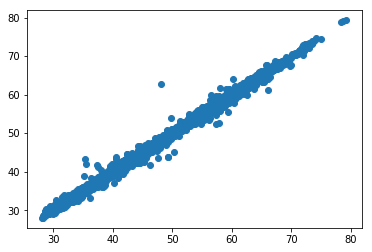

*** Training Model for 1JHC ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',


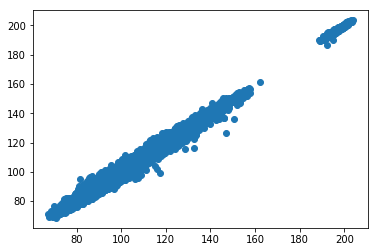

*** Training Model for 2JHH ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='obje

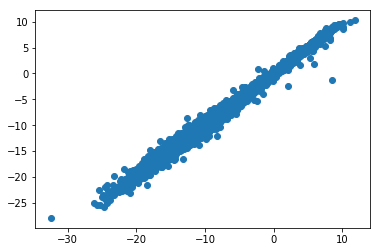

*** Training Model for 2JHN ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='obje

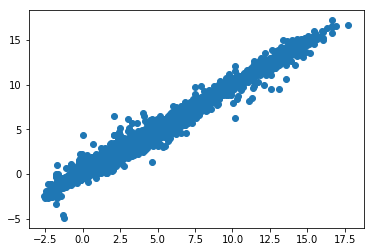

*** Training Model for 2JHC ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='obje

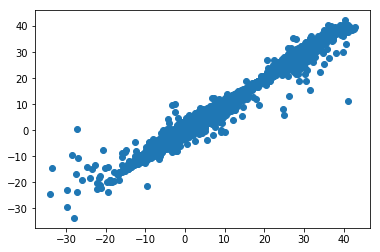

*** Training Model for 3JHH ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='obje

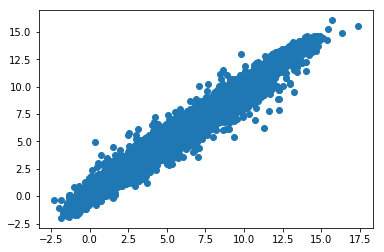

*** Training Model for 3JHC ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',


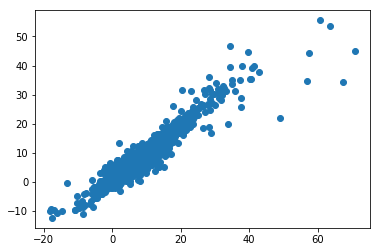

*** Training Model for 3JHN ***
Index(['linkM0', 'linkM1', 'inv_dist0R', 'mean_molecule_atom_0_dist_xyz',
       'max_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'sd_molecule_atom_1_dist_xyz', 'coulomb_C.x', 'coulomb_H.x',
       'coulomb_N.x', 'coulomb_O.x', 'yukawa_H.x', 'coulomb_C.y',
       'coulomb_H.y', 'coulomb_O.y', 'yukawa_C.y', 'yukawa_H.y', 'vander_C.y',
       'distC0', 'distC1', 'adH1', 'adC2', 'adC3', 'adC4', 'molecule_index',
       'mulliken_min', 'mulliken_max', 'mulliken_atom_0', 'mulliken_atom_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',


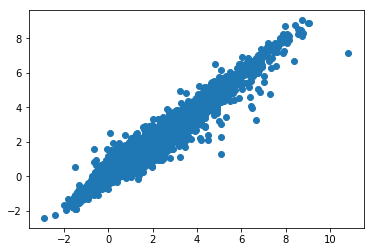

In [33]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}

N_FOLDS = 5
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

In [34]:
#每个耦合类型的CV得分
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHN,-1.182785
1,1JHC,-0.543226
2,2JHH,-1.981472
3,2JHN,-1.930218
4,2JHC,-1.406780
5,3JHH,-1.821495
6,3JHC,-1.349728
7,3JHN,-2.185601


In [35]:
#CV得分均值
np.mean(list(cv_scores.values()))

-1.5501629836049817

In [36]:
submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [37]:
submission.head(10)

,scalar_coupling_constant
id,
4658147,17.896688
4658148,152.958954
4658149,10.104980
4658150,150.669815
4658151,18.489357
4658152,91.235405
4658153,3.183611
4658154,-7.594494
4658155,-9.611823


In [38]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 